In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

idx = pd.IndexSlice

In [5]:
data_file = "../data-out/combined.tsv"
df = pd.read_csv(data_file, sep="\t")

df['game_id'] = range(1, len(df) + 1)
df['home_scorers'] = df['home_scorers'].fillna('NULL')
df['away_scorers'] = df['away_scorers'].fillna('NULL')

print df.shape
print df.iloc[0]

(4940, 10)
season                                               2001-2002
date                                                2002-06-11
home_team                                     Blackburn Rovers
home_score                                                   3
home_scorers    Andy Cole,53,g;Damien Duff,66,g;Andy Cole,81,g
away_team                                               Fulham
away_score                                                   0
away_scorers                                              NULL
venue                                               Ewood Park
game_id                                                      1
Name: 0, dtype: object


In [6]:
print df[['home_score', 'away_score']].describe()

        home_score   away_score
count  4940.000000  4940.000000
mean      1.523279     1.129555
std       1.301200     1.121229
min       0.000000     0.000000
25%       1.000000     0.000000
50%       1.000000     1.000000
75%       2.000000     2.000000
max       9.000000     6.000000


        games      freq
result                 
home     2286  0.462753
away     1374  0.278138
draw     1280  0.259109
Axes(0.125,0.125;0.775x0.775)


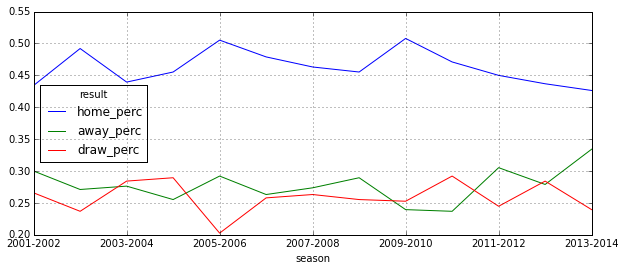

In [7]:
def get_result(row):
    h, a = row.home_score, row.away_score
    return 'draw' if h == a else 'home' if h > a else 'away'

df['result'] = df.apply(get_result, axis=1)

results = pd.DataFrame()
results['games'] = df.groupby('result').size().order(ascending=False)
results['freq'] = (results.games / sum(results.games)).astype(float)

print results

# by year
results_by_season = df.groupby('season')['result'].agg({
    'home': lambda x: sum(x == 'home') * 1.0 / len(x),
    'away': lambda x: sum(x == 'away') * 1.0 / len(x),
    'draw': lambda x: sum(x == 'draw') * 1.0 / len(x)
})

by_season = df.groupby(['season', 'result']).size().unstack()
by_season['tot'] = by_season[['home', 'away', 'draw']].apply(np.sum, axis=1)
for col in ['home', 'away', 'draw']:
    by_season['%s_perc' % col] = (by_season[col] / by_season.tot).astype(float)

print by_season[['home_perc', 'away_perc', 'draw_perc']].plot(figsize=(10, 4))

In [8]:
df['total_goals'] = df['home_score'] + df['away_score']

tot_goals = pd.DataFrame()
tot_goals['games'] = df.groupby('total_goals').size().order(ascending=False)
tot_goals['freq'] = (tot_goals.games / sum(tot_goals.games)).astype(float)

print tot_goals.head(10)

             games      freq
total_goals                 
2             1187  0.240283
3             1068  0.216194
1              885  0.179150
4              752  0.152227
0              412  0.083401
5              365  0.073887
6              154  0.031174
7               70  0.014170
8               35  0.007085
9                6  0.001215


In [9]:
# most popular final scores
def score_norm(row):
    scores = sorted([row.home_score, row.away_score], reverse=True)
    return '-'.join(str(s) for s in scores)

df['final_score'] = df.apply(score_norm, axis=1)

scores = pd.DataFrame()
scores['games'] = df.groupby('final_score').size().order(ascending=False)
scores['freq'] = (scores.games / sum(scores.games)).astype(float)

print scores.head(10)

             games      freq
final_score                 
1-0            885  0.179150
2-1            757  0.153239
2-0            630  0.127530
1-1            557  0.112753
0-0            412  0.083401
3-1            354  0.071660
3-0            311  0.062955
2-2            255  0.051619
3-2            198  0.040081
4-0            143  0.028947


In [10]:
# add time of first goal column(s)
def first_goal_time(g_data):
    goals = [g.split(',') for g in g_data.split(';')]
    
    times = []
    for g in goals:
        if len(g) == 3:
            times.append(int(g[1]))
                
    return min(times) if len(times) > 0 else None


df['home_g1'] = df['home_scorers'].apply(lambda x: first_goal_time(x))
df['away_g1'] = df['away_scorers'].apply(lambda x: first_goal_time(x))

# check that it worked
print df[['home_scorers', 'home_g1', 'away_scorers', 'away_g1']].head()

                                        home_scorers  home_g1  \
0     Andy Cole,53,g;Damien Duff,66,g;Andy Cole,81,g       53   
1                Paul Dickov,60,g;Matthew Piper,71,g       60   
2  John Arne Riise,13,g;John Arne Riise,35,g;Nico...       13   
3                   Steve Lomas,45,g;Ian Pearce,89,g       45   
4                                Kevin Phillips,17,g       17   

            away_scorers  away_g1  
0                   NULL      NaN  
1  Teddy Sheringham,54,g       54  
2                   NULL      NaN  
3   Youri Djorkaeff,67,g       67  
4   Marvin Robinson,68,g       68  


In [11]:
df.groupby('result').size()

result
away      1374
draw      1280
home      2286
dtype: int64

In [12]:
dfs = {}
for side in ['home', 'away']:    
    df_side = df.copy()
    
    new_names = {}
    for col in ['team', 'score', 'scorers', 'g1']:
        new_names['%s_%s' % (side, col)] = col
    df_side.rename(columns=new_names, inplace=True)

    df_side['side'] = side
    df_side['result'] = df_side['result'].apply(lambda x: 
        'draw' if x == 'draw' else 'win' if x == side else 'loss')

    cols_to_keep = ['game_id', 'date', 'season',
                    'team', 'score', 'scorers', 'g1', 
                   'side', 'result']
    df_side = df_side[cols_to_keep]
    
    dfs[side] = df_side

dg = dfs['home'].append(dfs['away'])

# check that it worked
print len(dg)
print len(dg.game_id.unique())

dg[dg.game_id == 1]

9880
4940


,game_id,date,season,team,score,scorers,g1,side,result
0,1,2002-06-11,2001-2002,Blackburn Rovers,3,"Andy Cole,53,g;Damien Duff,66,g;Andy Cole,81,g",53,home,win
0,1,2002-06-11,2001-2002,Fulham,0,NULL,NaN,away,loss


In [13]:
# goals by team
team_goals = dg.groupby('team')['score'].agg({'goals_avg': np.mean, 'goals_med': np.median})
team_goals.sort('goals_avg', ascending=False, inplace=True)

print team_goals.head(10)

                   goals_avg  goals_med
team                                   
Manchester United   2.004049        2.0
Arsenal             1.965587        2.0
Chelsea             1.880567        2.0
Liverpool           1.647773        1.0
Manchester City     1.574561        1.0
Tottenham Hotspur   1.459514        1.0
Blackpool           1.447368        1.5
Newcastle United    1.331140        1.0
Everton             1.329960        1.0
Leeds United        1.324561        1.0


In [14]:
print dg.groupby(['team', 'score']).size().unstack().fillna(0)

score                   0    1    2   3   4   5  6  7  8  9
team                                                       
Arsenal                63  150  128  86  43  13  7  4  0  0
Aston Villa           151  175  105  40  16   5  2  0  0  0
Birmingham             60   49   30  10   2   1  0  0  0  0
Birmingham City        32   52   23   5   2   0  0  0  0  0
Blackburn Rovers      126  143   94  39  13   2  0  1  0  0
Blackpool               8   11   15   2   2   0  0  0  0  0
Bolton Wanderers      132  147   92  27  17   3  0  0  0  0
Burnley                13   15    5   3   2   0  0  0  0  0
Cardiff City           19   10    5   4   0   0  0  0  0  0
Charlton Athletic      77   81   47  16   7   0  0  0  0  0
Chelsea                78  145  136  69  43  12  6  3  2  0
Crystal Palace         28   28   12   8   0   0  0  0  0  0
Derby County           39   25    8   4   0   0  0  0  0  0
Everton               126  167  134  52  11   3  0  1  0  0
Fulham                157  175  109  44 

In [15]:
# join df with itself to pull in opponent score and first goal info
dg2 = dg.copy()
dg2['side_opp'] = dg['side'].apply(lambda x: 'away' if x == 'home' else 'home')
dg2 = dg2[['game_id', 'side_opp', 'score', 'g1']]

dh = pd.merge(dg, dg2, left_on=['game_id', 'side'], right_on=['game_id', 'side_opp'], suffixes=['', '_opp'])

# check that it worked
dh[dh.game_id == 1]

,game_id,date,season,team,score,scorers,g1,side,result,side_opp,score_opp,g1_opp
0,1,2002-06-11,2001-2002,Blackburn Rovers,3,"Andy Cole,53,g;Damien Duff,66,g;Andy Cole,81,g",53,home,win,home,0,NaN
4940,1,2002-06-11,2001-2002,Fulham,0,NULL,NaN,away,loss,away,3,53


In [16]:
# checking for and removing bad data
bad_rows = dh[((dh.score > 0) & (pd.isnull(dh.g1))) | ((dh.score == 0) & (dh.g1.notnull()))]

# how many bad rows
print len(bad_rows)

# what seasons are they in
print bad_rows.season.value_counts()

# df size pre bad row zapping
print len(dh)

# remove these bad rows
dh = dh[~dh.game_id.isin(bad_rows.game_id.values)]

# df size post bad row zapping
print len(dh)

83
2013-2014    75
2002-2003     6
2005-2006     2
dtype: int64
9880
9772


In [17]:
# add indicator of whether team scored first
def scored_first(r):
    return True if r.score > 0 and (r.score_opp == 0 or r.g1 < r.g1_opp) else False

dh['scored_first'] = dh.apply(lambda row: scored_first(row), axis=1)

dh.iloc[0]

game_id                                                      1
date                                                2002-06-11
season                                               2001-2002
team                                          Blackburn Rovers
score                                                        3
scorers         Andy Cole,53,g;Damien Duff,66,g;Andy Cole,81,g
g1                                                          53
side                                                      home
result                                                     win
side_opp                                                  home
score_opp                                                    0
g1_opp                                                     NaN
scored_first                                              True
Name: 0, dtype: object

In [18]:
# what is the final outcome if a team scores first?
first_score_outcome = pd.DataFrame()
first_score_outcome['result'] = dh[dh.scored_first].groupby('result').size().order(ascending=False)
first_score_outcome['freq'] = (first_score_outcome['result'] / sum(first_score_outcome['result'])).astype(float)

print first_score_outcome

        result      freq
result                  
win       3086  0.690380
draw       857  0.191723
loss       527  0.117897


In [19]:
# win rate after scoring first by team
by_team = dh[dh.scored_first].groupby('team')['result'].agg({
        'win_rate': lambda x: sum(x == 'win') * 1.0 / len(x)
})

print by_team.sort('win_rate', ascending=False)

                      win_rate
team                          
Manchester United     0.870662
Chelsea               0.825397
Manchester City       0.796537
Arsenal               0.793333
Liverpool             0.788732
Birmingham            0.745098
Tottenham Hotspur     0.703252
Everton               0.702128
Charlton Athletic     0.670330
Middlesboro           0.669291
Blackburn Rovers      0.666667
Swansea City          0.666667
Newcastle United      0.653659
Leeds United          0.649123
Portsmouth            0.643564
Fulham                0.635417
West Ham United       0.630573
Southampton           0.628866
Reading               0.625000
Bolton Wanderers      0.623656
Sheffield United      0.615385
Stoke City            0.615385
West Bromwich Albion  0.608247
Aston Villa           0.604651
Birmingham City       0.581395
Sunderland            0.578571
Wigan Athletic        0.571429
Blackpool             0.571429
Ipswich Town          0.571429
Cardiff City          0.555556
Norwich 

In [20]:
dg.iloc[0]

game_id                                                 1
date                                           2002-06-11
season                                          2001-2002
team                                     Blackburn Rovers
score                                                   3
scorers    Andy Cole,53,g;Damien Duff,66,g;Andy Cole,81,g
g1                                                     53
side                                                 home
result                                                win
Name: 0, dtype: object

In [21]:
# new dataframe around goals
data = []
for i, r in dg.iterrows():
    if r.scorers != 'NULL':
        goals = r.scorers.split(';')
        for goal in goals:
            goal_info = goal.split(',')
            other_info = [r.game_id, r.season, r.team, r.side, r.result, r.score]
            combined = other_info + goal_info
            data.append(combined)

cols = ['game_id', 'season', 'team', 'side', 'result', 'tot_goals', 'player', 'time', 'type']
goals_df = pd.DataFrame(data, columns=cols)

goals_df['time'] = goals_df['time'].astype(int)

print len(goals_df)
print goals_df.head()

13001
   game_id     season              team  side result  tot_goals  \
0        1  2001-2002  Blackburn Rovers  home    win          3   
1        1  2001-2002  Blackburn Rovers  home    win          3   
2        1  2001-2002  Blackburn Rovers  home    win          3   
3        2  2001-2002    Leicester City  home    win          2   
4        2  2001-2002    Leicester City  home    win          2   

          player  time type  
0      Andy Cole    53    g  
1    Damien Duff    66    g  
2      Andy Cole    81    g  
3    Paul Dickov    60    g  
4  Matthew Piper    71    g  


In [51]:
goals_df.time.describe()

count    13001.000000
mean        50.486501
std         26.406922
min          0.000000
25%         29.000000
50%         51.000000
75%         74.000000
max         95.000000
Name: time, dtype: float64

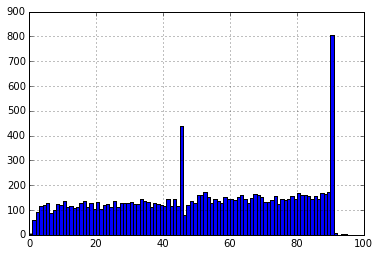

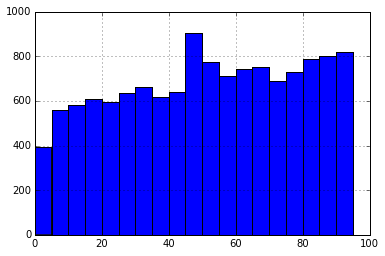

In [23]:
goals_df.time.hist(bins=95)

plt.figure()

goals_df.time.hist(bins=19)

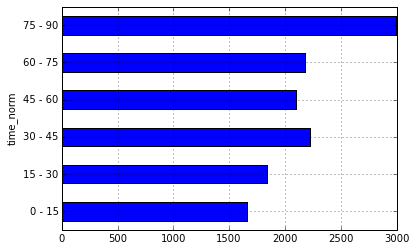

In [96]:
def time_norm(t, bin=5):
    t_start = max(min(t, 90) - 1, 0) / bin * bin
    return '%d - %d' % (t_start, t_start + bin)

goals_df['time_norm'] = goals_df['time'].apply(lambda x: time_norm(x, 15))

goals_df.groupby('time_norm').size().plot(kind='barh')

In [118]:
gtimes = goals_df.groupby(['time_norm', 'team']).size().unstack(level=0)

gtimes["tot"] = gtimes.sum(axis=1)
gtimes = gtimes[gtimes.tot >= 200]

gtimes.loc[:, "0 - 15":"75 - 90"] = gtimes.loc[:, "0 - 15":"75 - 90"].div(gtimes["tot"], axis=0)

gtimes

time_norm,0 - 15,15 - 30,30 - 45,45 - 60,60 - 75,75 - 90,tot
team,,,,,,,
Arsenal,0.130073,0.141519,0.170656,0.157128,0.150884,0.249740,961
Aston Villa,0.142149,0.157025,0.171901,0.161983,0.165289,0.201653,605
Blackburn Rovers,0.103113,0.161479,0.178988,0.180934,0.161479,0.214008,514
Bolton Wanderers,0.151822,0.123482,0.186235,0.147773,0.159919,0.230769,494
Charlton Athletic,0.119522,0.155378,0.175299,0.171315,0.123506,0.254980,251
Chelsea,0.108696,0.147826,0.184783,0.163043,0.168478,0.227174,920
Everton,0.116564,0.134969,0.177914,0.151840,0.154908,0.263804,652
Fulham,0.123693,0.134146,0.163763,0.160279,0.193380,0.224739,574
Liverpool,0.127004,0.145499,0.157830,0.176326,0.183724,0.209618,811


In [98]:
goals_df.groupby(['time_norm', 'team']).size().unstack(level=0)

time_norm,0 - 15,15 - 30,30 - 45,45 - 60,60 - 75,75 - 90
team,,,,,,
Arsenal,125,136,164,151,145,240
Aston Villa,86,95,104,98,100,122
Birmingham,17,17,31,17,29,39
Birmingham City,13,18,21,20,20,29
Blackburn Rovers,53,83,92,93,83,110
Blackpool,8,7,13,6,8,13
Bolton Wanderers,75,61,92,73,79,114
Burnley,6,4,5,8,9,10
Cardiff City,5,3,2,8,7,7


In [24]:
goals_df[goals_df.game_id == 55]

,game_id,season,team,side,result,tot_goals,player,time,type
84,55,2001-2002,Sunderland,home,win,2,Claudio Reyna,3,g
85,55,2001-2002,Sunderland,home,win,2,Claudio Reyna,18,g
7518,55,2001-2002,Leicester City,away,loss,1,Paul Dickov,9,g


In [25]:
# how often is at least 1 goal scored within first n mins?
cutoff = 10

g1 = goals_df.groupby('game_id')['time'].agg({'time': min})

print len(g1[g1.time < cutoff]) * 1.0 / len(g1)

0.196074057551


In [26]:
# summary stats on when first goal is scored
g1.time.describe()

count    4483.000000
mean       31.245148
std        23.052051
min         0.000000
25%        12.000000
50%        26.000000
75%        45.000000
max        93.000000
Name: time, dtype: float64

In [27]:
def get_stats(data):
    times = sorted(data.values)
    g2_g1_diff = times[1] - times[0] if len(times) > 1 else None
    return {
        'n': len(times),
        'min': min(times), 
        'max': max(times), 
        'all': times,
        'g2_g1_diff': g2_g1_diff,
    }

g_time_df = goals_df.groupby('game_id')['time'].apply(get_stats).unstack()

float_cols = ['min', 'max', 'n', 'g2_g1_diff']
g_time_df[float_cols] = g_time_df[float_cols].astype(float)

print g_time_df.head(10)

                                 all  g2_g1_diff  max  min  n
game_id                                                      
1                       [53, 66, 81]          13   81   53  3
2                       [54, 60, 71]           6   71   54  3
3               [13, 35, 46, 57, 88]          22   88   13  5
4                       [45, 67, 89]          22   89   45  3
5                           [17, 68]          51   68   17  2
6                   [21, 63, 70, 88]          42   88   21  4
8                   [17, 24, 55, 90]           7   90   17  4
9                               [63]         NaN   63   63  1
10       [4, 20, 31, 33, 72, 83, 89]          16   89    4  7
11                              [57]         NaN   57   57  1


In [28]:
two_plus_games = g_time_df.copy()
two_plus_games = two_plus_games[two_plus_games.n > 1]

print two_plus_games['min'].describe()

print two_plus_games['g2_g1_diff'].describe()

count    3612.000000
mean       26.559801
std        19.615157
min         0.000000
25%        10.000000
50%        22.000000
75%        39.000000
max        90.000000
Name: min, dtype: float64
count    3612.000000
mean       24.119048
std        18.344007
min         0.000000
25%         9.000000
50%        20.000000
75%        34.250000
max        89.000000
Name: g2_g1_diff, dtype: float64


In [29]:
goals_df = goals_df.sort(['game_id', 'time'], ascending=[1, 1])

# 1/0 for home/away goals at each score times
scores_by_time = goals_df.groupby(['game_id', 'time', 'side']).size().unstack().fillna(0)

# cumulative goals for home/away by game
scores_by_time = scores_by_time.groupby(level=[0]).cumsum()

print scores_by_time.head(10)

side          away  home
game_id time            
1       53       0     1
        66       0     2
        81       0     3
2       54       1     0
        60       1     1
        71       1     2
3       13       0     1
        35       0     2
        46       0     3
        57       0     4


In [30]:
print scores_by_time.loc[idx[[10],:], :]

side          away  home
game_id time            
10      4        0     1
        20       1     1
        31       2     1
        33       2     2
        72       2     3
        83       2     4
        89       3     4


In [31]:
away = scores_by_time.unstack()['away'].fillna(method='ffill', axis=1).fillna(0).stack()
home = scores_by_time.unstack()['home'].fillna(method='ffill', axis=1).fillna(0).stack()

scores_dense = pd.DataFrame()

scores_dense['away'] = away
scores_dense['home'] = home

# add goal diff column
scores_dense['diff'] = scores_dense['home'] - scores_dense['away']

# check that it worked
scores_dense.loc[idx[[10], :], :].head(10)

away  home  diff
game_id time                  
10      0        0     0     0
        1        0     0     0
        2        0     0     0
        3        0     0     0
        4        0     1     1
        5        0     1     1
        6        0     1     1
        7        0     1     1
        8        0     1     1
        9        0     1     1

In [135]:
# pull in final result
scores_dense_w_result = pd.merge(scores_dense.reset_index(), df[['game_id', 'result']], on='game_id')

g = scores_dense_w_result.groupby(['time', 'diff'])

games = g['game_id'].agg({'games': len})
results = g['result'].agg({
    'home': lambda x: sum(x == 'home'),
    'away': lambda x: sum(x == 'away'),
    'draw': lambda x: sum(x == 'draw'),
})

by_time_summary = games.join(results)

by_time_summary = by_time_summary.unstack(level=1).fillna(0).stack().loc[idx[:, -3:3], :]

by_time_summary.head(10)

games  home  away  draw
time diff                         
0    -3        0     0     0     0
     -2        0     0     0     0
     -1        2     2     0     0
      0     4480  2261  1358   861
      1        1     0     1     0
      2        0     0     0     0
      3        0     0     0     0
1    -3        0     0     0     0
     -2        0     0     0     0
     -1       28     7    14     7

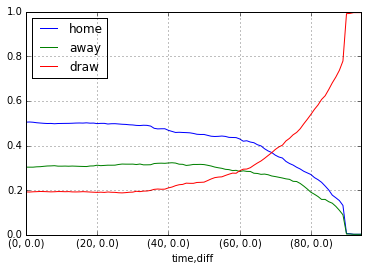

In [141]:
zero_diff = by_time_summary.copy()
zero_diff = zero_diff.loc[idx[:, [0]], :]

for col in ['home', 'away', 'draw']:
    zero_diff[col] = (zero_diff[col] / zero_diff.games).astype(float)

zero_diff[['home', 'away', 'draw']].plot()

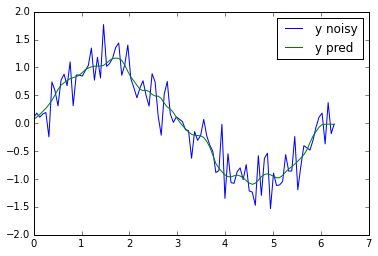

In [50]:
import math

n = 100
x = np.linspace(0, 2 * math.pi, n)
y = np.sin(x) + 0.3*np.random.randn(n)

f = 0.1
lowess = sm.nonparametric.lowess(y, x, frac=f)

plt.clf()
plt.plot(x, y, label='y noisy')
plt.plot(x, lowess[:,1], label='y pred')
plt.legend()
plt.show()